<a href="https://colab.research.google.com/github/ishneha1/AI_practice/blob/main/LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Create a Spark session
spark = SparkSession.builder.appName("RegressionDiagnostics").getOrCreate()
# Load the marketing dataset
data = [
(149.96, 26.1, 22.0),
(190.2, 45.0, 69.0),
(192.58, 46.2, 58.0),
(270.16, 54.5, 88.0),
(78.88, 17.6, 14.0),
]
# Create DataFrame with columns: sales, youtube, facebook
df = spark.createDataFrame(data, ["sales", "youtube", "facebook"])
df.show()

+------+-------+--------+
| sales|youtube|facebook|
+------+-------+--------+
|149.96|   26.1|    22.0|
| 190.2|   45.0|    69.0|
|192.58|   46.2|    58.0|
|270.16|   54.5|    88.0|
| 78.88|   17.6|    14.0|
+------+-------+--------+



In [3]:
print("\n" + "="*70)
print("PART 2: Simple Model - Sales ~ YouTube")
print("="*70)
# Prepare data for model (combine youtube column into features vector)
assembler = VectorAssembler(inputCols=["youtube"], outputCol="features")
df_model1 = assembler.transform(df)
# Fit the linear regression model
model1 = LinearRegression(featuresCol="features", labelCol="sales")
fitted1 = model1.fit(df_model1)
# Get predictions and calculate residuals
predictions1 = fitted1.transform(df_model1)
predictions1 = predictions1.withColumn("residuals",
predictions1.sales - predictions1.prediction)
# Show predictions and residuals
print("\nPredictions and Residuals:")
predictions1.select("youtube", "sales", "prediction", "residuals").show()
# Print model coefficients
print(f"\nIntercept: {fitted1.intercept:.4f}")
print(f"Slope (YouTube coefficient): {fitted1.coefficients[0]:.4f}")


PART 2: Simple Model - Sales ~ YouTube

Predictions and Residuals:
+-------+------+------------------+-------------------+
|youtube| sales|        prediction|          residuals|
+-------+------+------------------+-------------------+
|   26.1|149.96|125.55602176311695| 24.403978236883063|
|   45.0| 190.2| 207.0602313282349|-16.860231328234903|
|   46.2|192.58|212.23510177681382|-19.655101776813808|
|   54.5|270.16|  248.027955712818| 22.132044287182026|
|   17.6| 78.88| 88.90068941901629|-10.020689419016293|
+-------+------+------------------+-------------------+


Intercept: 13.0026
Slope (YouTube coefficient): 4.3124



PART 3: Diagnostic Plots

Mean of residuals: 0.000000 (should be close to 0)


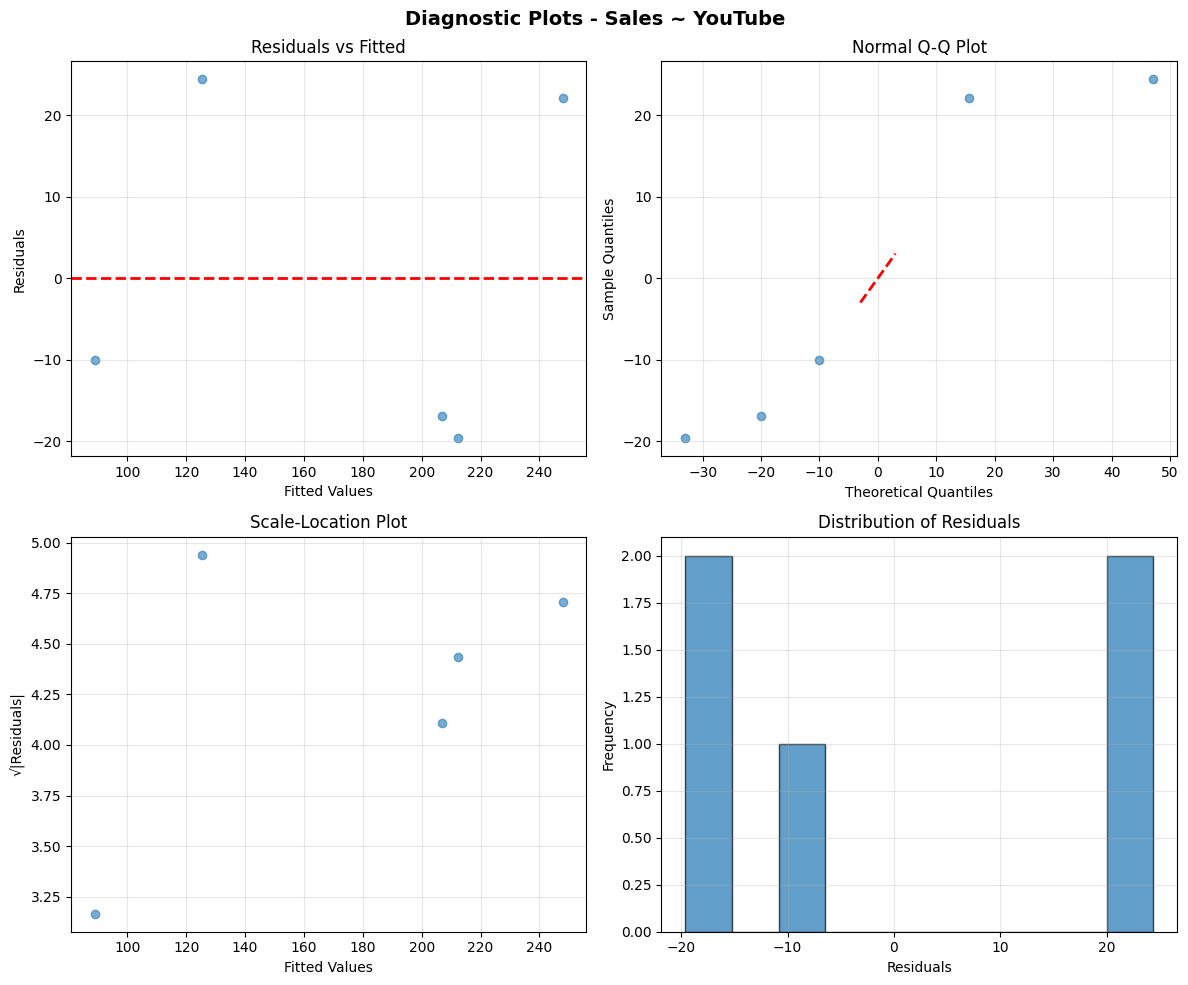

In [4]:
print("\n" + "="*70)
print("PART 3: Diagnostic Plots")
print("="*70)
# Convert to Pandas for easier plotting
pred_pd1 = predictions1.select("prediction", "residuals", "sales").toPandas()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Diagnostic Plots - Sales ~ YouTube', fontsize=14, fontweight='bold')
# Plot 1: Residuals vs Fitted Values
ax1 = axes[0, 0]
ax1.scatter(pred_pd1["prediction"], pred_pd1["residuals"], alpha=0.6)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted')
ax1.grid(True, alpha=0.3)
# Check for pattern
mean_resid = pred_pd1["residuals"].mean()
print(f"\nMean of residuals: {mean_resid:.6f} (should be close to 0)")
# Plot 2: Q-Q Plot (Normal probability plot)
ax2 = axes[0, 1]
sorted_resid = np.sort(pred_pd1["residuals"])
theoretical = np.sort(np.random.normal(0, pred_pd1["residuals"].std(), len(sorted_resid)))
ax2.scatter(theoretical, sorted_resid, alpha=0.6)
ax2.plot([-3, 3], [-3, 3], 'r--', linewidth=2)
ax2.set_xlabel('Theoretical Quantiles')
ax2.set_ylabel('Sample Quantiles')
ax2.set_title('Normal Q-Q Plot')
ax2.grid(True, alpha=0.3)
# Plot 3: Scale-Location Plot
ax3 = axes[1, 0]
sqrt_abs_resid = np.sqrt(np.abs(pred_pd1["residuals"]))
ax3.scatter(pred_pd1["prediction"], sqrt_abs_resid, alpha=0.6)
ax3.set_xlabel('Fitted Values')
ax3.set_ylabel('√|Residuals|')
ax3.set_title('Scale-Location Plot')
ax3.grid(True, alpha=0.3)
# Plot 4: Histogram of Residuals
ax4 = axes[1, 1]
ax4.hist(pred_pd1["residuals"], bins=10, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Residuals')
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
from pyspark.ml.evaluation import RegressionEvaluator
# Calculate R-squared for Model 1
evaluator = RegressionEvaluator(labelCol="sales", predictionCol="prediction",
metricName="r2")
r2_model1 = evaluator.evaluate(predictions1)
print(f"Model 1 (Sales ~ YouTube):")
print(f" R² = {r2_model1:.4f}")
print(f" Explained variance: {r2_model1*100:.2f}%")

Model 1 (Sales ~ YouTube):
 R² = 0.9046
 Explained variance: 90.46%


In [6]:
print("\n" + "="*70)
print("PART 5: Multiple Regression - Sales ~ YouTube + Facebook")
print("="*70)
# Prepare data with two predictors
assembler2 = VectorAssembler(inputCols=["youtube", "facebook"], outputCol="features")
df_model2 = assembler2.transform(df)
# Fit the model
model2 = LinearRegression(featuresCol="features", labelCol="sales")
fitted2 = model2.fit(df_model2)
# Get predictions and residuals
predictions2 = fitted2.transform(df_model2)
predictions2 = predictions2.withColumn("residuals",
predictions2.sales - predictions2.prediction)
# Show results
print("\nPredictions and Residuals:")
predictions2.select("youtube", "facebook", "sales", "prediction", "residuals").show()
# Print model coefficients
print(f"\nIntercept: {fitted2.intercept:.4f}")
print(f"YouTube coefficient: {fitted2.coefficients[0]:.4f}")
print(f"Facebook coefficient: {fitted2.coefficients[1]:.4f}")
# Calculate R-squared
r2_model2 = evaluator.evaluate(predictions2)
print(f"\nR-squared: {r2_model2:.4f}")
print(f"Explained variance: {r2_model2*100:.2f}%")



PART 5: Multiple Regression - Sales ~ YouTube + Facebook

Predictions and Residuals:
+-------+--------+------+------------------+-------------------+
|youtube|facebook| sales|        prediction|          residuals|
+-------+--------+------+------------------+-------------------+
|   26.1|    22.0|149.96| 124.3759116427515| 25.584088357248504|
|   45.0|    69.0| 190.2|208.22112851362476|-18.021128513624774|
|   46.2|    58.0|192.58| 209.9789627390922|-17.398962739092184|
|   54.5|    88.0|270.16|249.18643619038608|  20.97356380961395|
|   17.6|    14.0| 78.88|  90.0175609141454| -11.13756091414541|
+-------+--------+------+------------------+-------------------+


Intercept: 19.5295
YouTube coefficient: 3.8022
Facebook coefficient: 0.2550

R-squared: 0.9051
Explained variance: 90.51%


In [8]:
print("\n" + "="*70)
print("PART 6: Model Comparison")
print("="*70)
print(f"\nModel 1 (Sales ~ YouTube):")
print(f" R² = {r2_model1:.4f} ({r2_model1*100:.2f}%)")
print(f"\nModel 2 (Sales ~ YouTube + Facebook):")
print(f" R² = {r2_model2:.4f} ({r2_model2*100:.2f}%)")
if r2_model2 > r2_model1:
  improvement = (r2_model2 - r2_model1) * 100
  print(f"\nModel 2 is better!")
  print(f"Improvement: {improvement:.2f} percentage points")
else:
  print(f"\nModel 1 is better!")


PART 6: Model Comparison

Model 1 (Sales ~ YouTube):
 R² = 0.9046 (90.46%)

Model 2 (Sales ~ YouTube + Facebook):
 R² = 0.9051 (90.51%)

Model 2 is better!
Improvement: 0.05 percentage points
